# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, keep K at 4 but lower embed dimen to 3.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 20:27:39.015354


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 3 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = [1]   # exclude H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: [1]


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 20:28:13.164379
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 3)           771       
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          1600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 20:28:13.503670
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 20:28:24.404530

Training # 1 1
2023-03-26 20:28:24.404790
2023-03-26 20:28:24.404842
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 20:28:25.600852


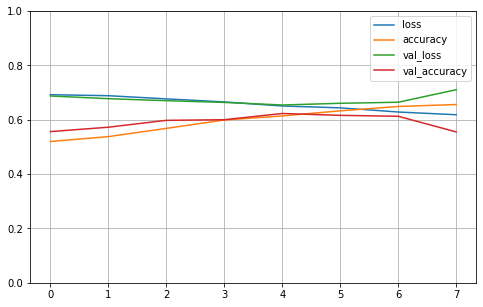


2023-03-26 20:28:48.300185

Testing # 1 1
2023-03-26 20:28:48.300280
2023-03-26 20:28:48.300315
PREDICT
2023-03-26 20:28:48.530177
Test 1:0 458:412 52.64%
Predict 1:0 237:633 27.24%
Test sizes (870, 4997) (870,)
Range of scores: 0.02795588 to 0.90449834
Score threshold 0.5
Confusion matrix
 [[329  83]
 [304 154]]
Normalized matrix
 [[0.37816092 0.0954023 ]
 [0.34942529 0.17701149]]


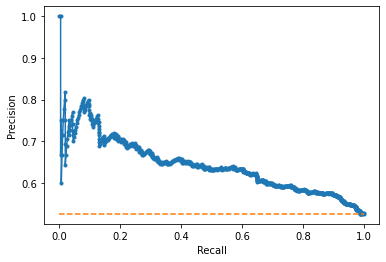

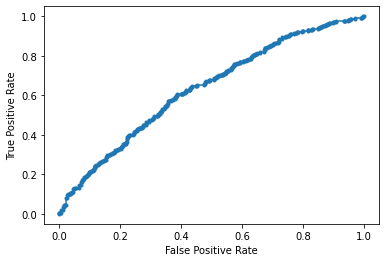

Accuracy: 55.52% Precision: 64.98% Recall: 33.62%
F1: 44.32% MCC: 0.1512
AUPRC: 64.24% AUROC: 63.50%
 accuracy [55.51724137931034]
 precision [64.9789029535865]
 recall [33.624454148471614]
 F1 [44.31654676258992]
 MCC [0.15116710358495544]
 AUPRC [64.24185642384911]
 AUROC [63.49896129223724]
2023-03-26 20:28:50.157397

Training # 1 2
2023-03-26 20:28:50.157638
2023-03-26 20:28:50.157683
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 20:28:51.358442


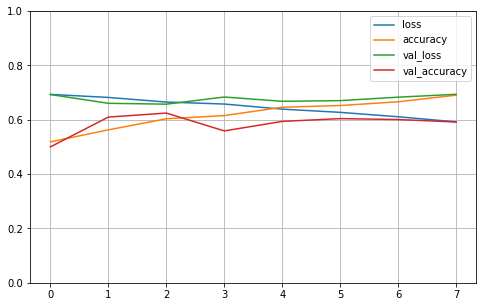


2023-03-26 20:29:05.521693

Testing # 1 2
2023-03-26 20:29:05.521782
2023-03-26 20:29:05.521815
PREDICT
2023-03-26 20:29:05.815647
Test 1:0 442:442 50.00%
Predict 1:0 443:441 50.11%
Test sizes (884, 4997) (884,)
Range of scores: 0.03992612 to 0.9332283
Score threshold 0.5
Confusion matrix
 [[261 181]
 [180 262]]
Normalized matrix
 [[0.29524887 0.20475113]
 [0.20361991 0.29638009]]


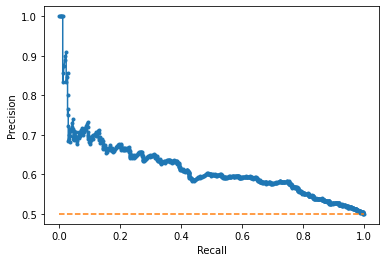

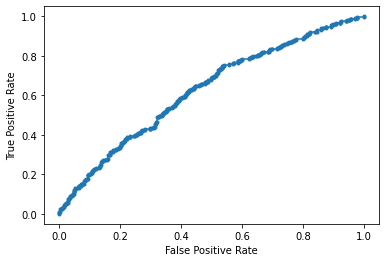

Accuracy: 59.16% Precision: 59.14% Recall: 59.28%
F1: 59.21% MCC: 0.1833
AUPRC: 61.34% AUROC: 62.51%
 accuracy [59.16289592760181]
 precision [59.14221218961625]
 recall [59.276018099547514]
 F1 [59.2090395480226]
 MCC [0.18325838757043794]
 AUPRC [61.338844389304455]
 AUROC [62.514588153395714]
2023-03-26 20:29:07.634423

Training # 1 3
2023-03-26 20:29:07.634644
2023-03-26 20:29:07.634694
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 20:29:09.343463


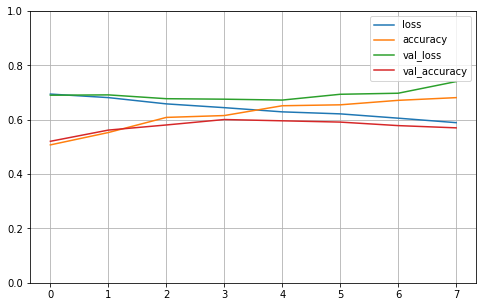


2023-03-26 20:29:23.100218

Testing # 1 3
2023-03-26 20:29:23.100316
2023-03-26 20:29:23.100352
PREDICT
2023-03-26 20:29:23.319963
Test 1:0 442:407 52.06%
Predict 1:0 617:232 72.67%
Test sizes (849, 4997) (849,)
Range of scores: 0.014758362 to 0.9700163
Score threshold 0.5
Confusion matrix
 [[137 270]
 [ 95 347]]
Normalized matrix
 [[0.16136631 0.3180212 ]
 [0.11189635 0.40871614]]


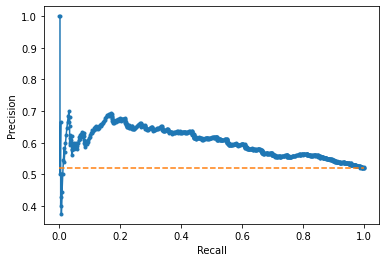

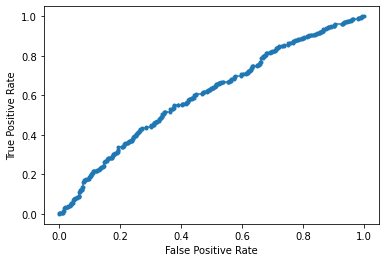

Accuracy: 57.01% Precision: 56.24% Recall: 78.51%
F1: 65.53% MCC: 0.1364
AUPRC: 60.12% AUROC: 60.28%
 accuracy [57.008244994110726]
 precision [56.23987034035657]
 recall [78.50678733031674]
 F1 [65.53352219074598]
 MCC [0.13640522538493485]
 AUPRC [60.12355233751791]
 AUROC [60.282722047427924]
2023-03-26 20:29:24.826136

Training # 1 4
2023-03-26 20:29:24.826321
2023-03-26 20:29:24.826374
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 20:29:26.012927


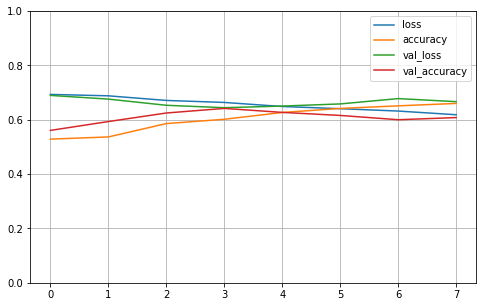


2023-03-26 20:29:41.060262

Testing # 1 4
2023-03-26 20:29:41.060364
2023-03-26 20:29:41.060398
PREDICT
2023-03-26 20:29:41.284011
Test 1:0 459:431 51.57%
Predict 1:0 620:270 69.66%
Test sizes (890, 4997) (890,)
Range of scores: 0.116351835 to 0.9281833
Score threshold 0.5
Confusion matrix
 [[176 255]
 [ 94 365]]
Normalized matrix
 [[0.19775281 0.28651685]
 [0.10561798 0.41011236]]


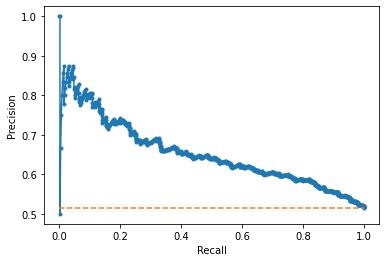

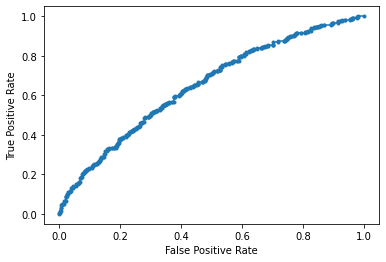

Accuracy: 60.79% Precision: 58.87% Recall: 79.52%
F1: 67.66% MCC: 0.2213
AUPRC: 65.30% AUROC: 64.91%
 accuracy [60.78651685393258]
 precision [58.87096774193549]
 recall [79.520697167756]
 F1 [67.65523632993512]
 MCC [0.22128854075635995]
 AUPRC [65.2961827926771]
 AUROC [64.9136375354473]
2023-03-26 20:29:43.804118

Training # 1 5
2023-03-26 20:29:43.804324
2023-03-26 20:29:43.804374
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 20:29:45.044060


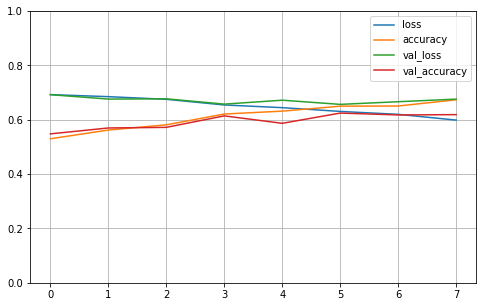


2023-03-26 20:29:59.702240

Testing # 1 5
2023-03-26 20:29:59.704772
2023-03-26 20:29:59.705200
PREDICT
2023-03-26 20:30:00.132901
Test 1:0 457:419 52.17%
Predict 1:0 549:327 62.67%
Test sizes (876, 4997) (876,)
Range of scores: 0.026960561 to 0.9629399
Score threshold 0.5
Confusion matrix
 [[206 213]
 [121 336]]
Normalized matrix
 [[0.23515982 0.24315068]
 [0.13812785 0.38356164]]


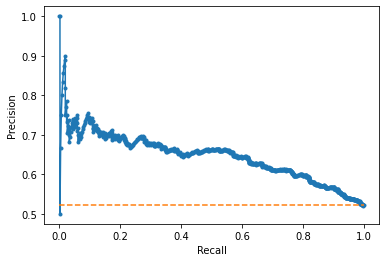

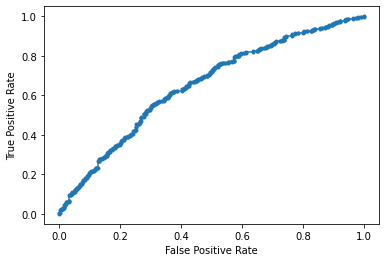

Accuracy: 61.87% Precision: 61.20% Recall: 73.52%
F1: 66.80% MCC: 0.2343
AUPRC: 64.65% AUROC: 65.13%
 accuracy [61.87214611872146]
 precision [61.20218579234973]
 recall [73.52297592997812]
 F1 [66.79920477137176]
 MCC [0.23431206321171721]
 AUPRC [64.64898221860769]
 AUROC [65.12745256759086]
2023-03-26 20:30:02.023507

Training # 2 1
2023-03-26 20:30:02.023702
2023-03-26 20:30:02.023749
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 20:30:03.179971


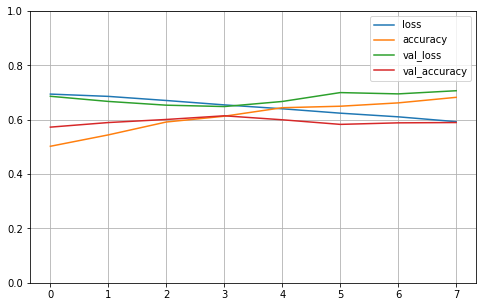


2023-03-26 20:30:25.007522

Testing # 2 1
2023-03-26 20:30:25.013133
2023-03-26 20:30:25.013466
PREDICT
2023-03-26 20:30:25.466083
Test 1:0 472:415 53.21%
Predict 1:0 620:267 69.90%
Test sizes (887, 4997) (887,)
Range of scores: 0.009326189 to 0.9781066
Score threshold 0.5
Confusion matrix
 [[159 256]
 [108 364]]
Normalized matrix
 [[0.17925592 0.2886133 ]
 [0.12175874 0.41037204]]


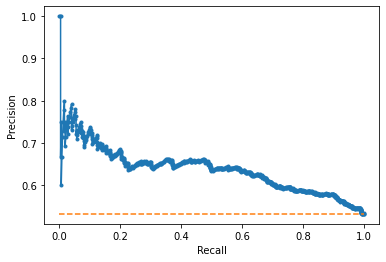

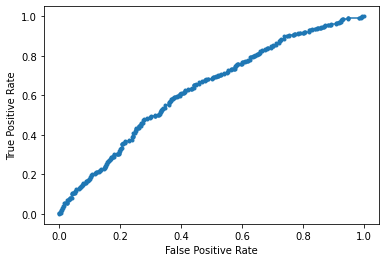

Accuracy: 58.96% Precision: 58.71% Recall: 77.12%
F1: 66.67% MCC: 0.1679
AUPRC: 63.82% AUROC: 63.10%
 accuracy [58.962795941375425]
 precision [58.70967741935483]
 recall [77.11864406779661]
 F1 [66.66666666666666]
 MCC [0.16786605739450458]
 AUPRC [63.819350984948244]
 AUROC [63.096793955482944]
2023-03-26 20:30:27.245618

Training # 2 2
2023-03-26 20:30:27.245831
2023-03-26 20:30:27.245877
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 20:30:28.572687


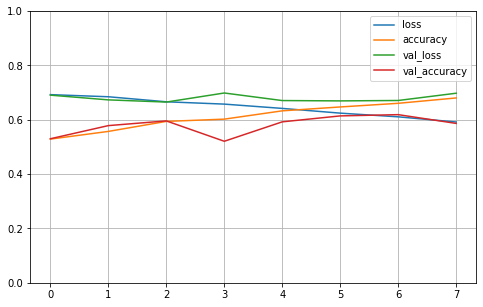


2023-03-26 20:30:50.317772

Testing # 2 2
2023-03-26 20:30:50.317887
2023-03-26 20:30:50.317923
PREDICT
2023-03-26 20:30:50.537572
Test 1:0 452:416 52.07%
Predict 1:0 271:597 31.22%
Test sizes (868, 4997) (868,)
Range of scores: 0.023068972 to 0.86297125
Score threshold 0.5
Confusion matrix
 [[327  89]
 [270 182]]
Normalized matrix
 [[0.37672811 0.10253456]
 [0.31105991 0.20967742]]


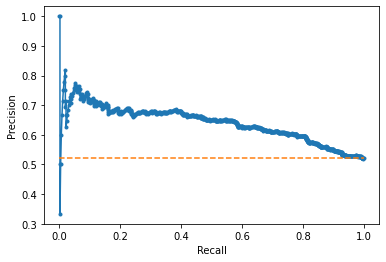

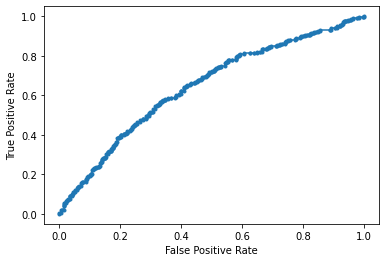

Accuracy: 58.64% Precision: 67.16% Recall: 40.27%
F1: 50.35% MCC: 0.2034
AUPRC: 64.06% AUROC: 64.41%
 accuracy [58.6405529953917]
 precision [67.15867158671587]
 recall [40.26548672566372]
 F1 [50.345781466113415]
 MCC [0.20344399566712923]
 AUPRC [64.06053340380156]
 AUROC [64.41297226004083]
2023-03-26 20:30:52.592226

Training # 2 3
2023-03-26 20:30:52.594134
2023-03-26 20:30:52.594459
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 20:30:54.251601


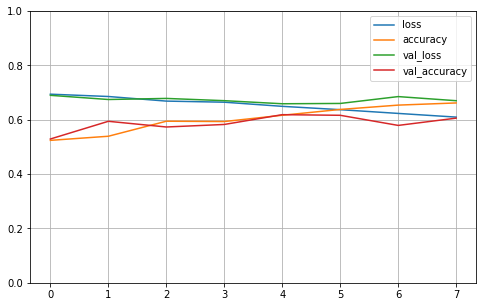


2023-03-26 20:31:16.015100

Testing # 2 3
2023-03-26 20:31:16.015529
2023-03-26 20:31:16.015567
PREDICT
2023-03-26 20:31:16.239589
Test 1:0 453:407 52.67%
Predict 1:0 404:456 46.98%
Test sizes (860, 4997) (860,)
Range of scores: 0.048040807 to 0.9695637
Score threshold 0.5
Confusion matrix
 [[262 145]
 [194 259]]
Normalized matrix
 [[0.30465116 0.16860465]
 [0.2255814  0.30116279]]


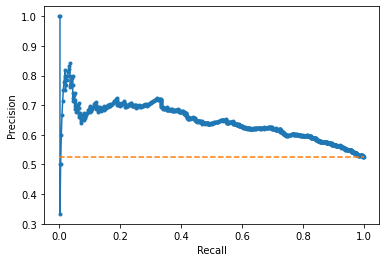

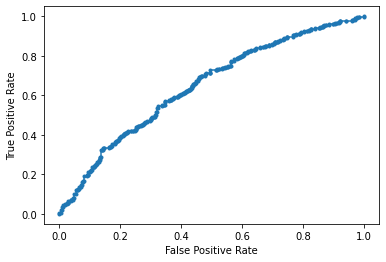

Accuracy: 60.58% Precision: 64.11% Recall: 57.17%
F1: 60.44% MCC: 0.2156
AUPRC: 64.62% AUROC: 64.69%
 accuracy [60.581395348837205]
 precision [64.10891089108911]
 recall [57.17439293598234]
 F1 [60.443407234539094]
 MCC [0.21556452561421058]
 AUPRC [64.61782323439758]
 AUROC [64.69075939274614]
2023-03-26 20:31:18.554529

Training # 2 4
2023-03-26 20:31:18.554738
2023-03-26 20:31:18.554783
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 20:31:20.315956


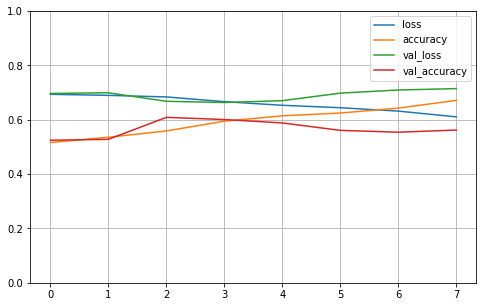


2023-03-26 20:31:42.118449

Testing # 2 4
2023-03-26 20:31:42.118572
2023-03-26 20:31:42.118609
PREDICT
2023-03-26 20:31:42.350312
Test 1:0 432:447 49.15%
Predict 1:0 305:574 34.70%
Test sizes (879, 4997) (879,)
Range of scores: 0.064621195 to 0.9720437
Score threshold 0.5
Confusion matrix
 [[318 129]
 [256 176]]
Normalized matrix
 [[0.36177474 0.14675768]
 [0.29124005 0.20022753]]


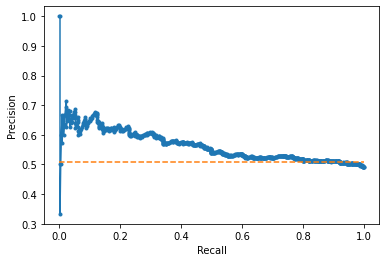

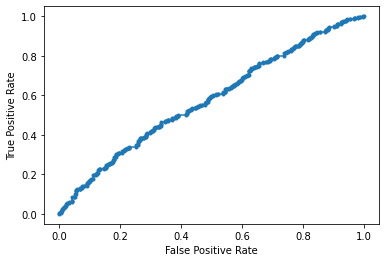

Accuracy: 56.20% Precision: 57.70% Recall: 40.74%
F1: 47.76% MCC: 0.1248
AUPRC: 56.35% AUROC: 57.80%
 accuracy [56.20022753128555]
 precision [57.70491803278689]
 recall [40.74074074074074]
 F1 [47.76119402985075]
 MCC [0.12478650842082795]
 AUPRC [56.35032298619633]
 AUROC [57.80304913414533]
2023-03-26 20:31:43.865130

Training # 2 5
2023-03-26 20:31:43.865832
2023-03-26 20:31:43.865878
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 20:31:46.055973


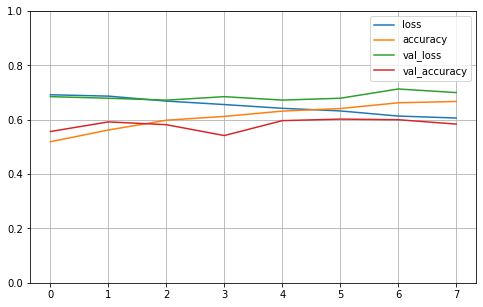


2023-03-26 20:32:07.832815

Testing # 2 5
2023-03-26 20:32:07.832917
2023-03-26 20:32:07.832954
PREDICT
2023-03-26 20:32:08.050473
Test 1:0 449:426 51.31%
Predict 1:0 461:414 52.69%
Test sizes (875, 4997) (875,)
Range of scores: 0.032374844 to 0.9800745
Score threshold 0.5
Confusion matrix
 [[238 188]
 [176 273]]
Normalized matrix
 [[0.272      0.21485714]
 [0.20114286 0.312     ]]


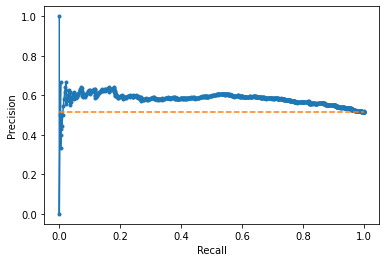

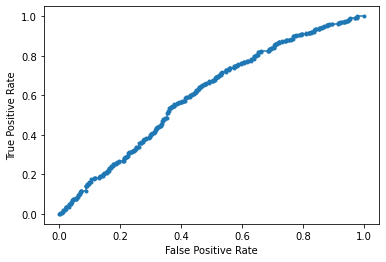

Accuracy: 58.40% Precision: 59.22% Recall: 60.80%
F1: 60.00% MCC: 0.1669
AUPRC: 58.20% AUROC: 60.55%
 accuracy [58.4]
 precision [59.219088937093275]
 recall [60.801781737193764]
 F1 [60.0]
 MCC [0.16688658909987714]
 AUPRC [58.20364563871383]
 AUROC [60.55083283666364]
2023-03-26 20:32:08.719360


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.71% std 2.04
 precision mean 60.73% std 3.54
 recall mean 60.06% std 17.21
 F1 mean 58.87% std 8.54
 MCC mean 0.18% std 0.04
 AUPRC mean 62.27% std 3.11
 AUROC mean 62.69% std 2.43
 accuracy [[55.51724137931034], [59.16289592760181], [57.008244994110726], [60.78651685393258], [61.87214611872146], [58.962795941375425], [58.6405529953917], [60.581395348837205], [56.20022753128555], [58.4]]
 precision [[64.9789029535865], [59.14221218961625], [56.23987034035657], [58.87096774193549], [61.20218579234973], [58.70967741935483], [67.15867158671587], [64.10891089108911], [57.70491803278689], [59.219088937093275]]
 recall [[33.624454148471614], [59.276018099547514], [78.50678733031674], [79.520697167756], [73.52297592997812], [77.11864406779661], [40.26548672566372], [57.17439293598234], [40.74074074074074], [60.801781737193764]]
 F1 [[44.31654676258992], [59.2090395480226], [65.53352219074598], [67.65523632993512], [66.79920477137176], [66.66666666666666], [50.345781466113415